# Distance-based colocalization
A common bio-image analysis task is counting cells and other objects depending on their existence in multiple channels and distances between these objects. When analyzing objects according to distances to object in other channels, one can also count different objects which express signal in different channels. If objects are in different places close-by, they are technically not colocalized, but the analysis shown here also work for these use-cases.

In [1]:
import pyclesperanto_prototype as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

cle.get_device()

<Intel(R) Iris(R) Xe Graphics on Platform: Intel(R) OpenCL HD Graphics (1 refs)>

We're using a dataset published by [Heriche et al.](https://doi.org/10.1091/mbc.E13-04-0221) licensed [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) available in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/img_detail/179719/).

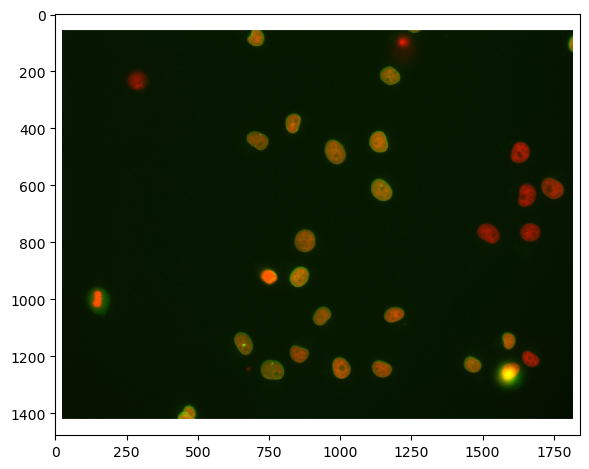

In [2]:
# load file
raw_image = imread('../../data/plate1_1_013 [Well 5, Field 1 (Spot 5)].png')

# pixel size (from meta data)
pixel_size_xy_in_micron = 0.32

# visualize
imshow(raw_image)

First, we need to split channels ([read more](https://github.com/BiAPoL/Bio-image_Analysis_with_Python/blob/a62070dee408814cee4258758f5187f135774519/image_processing/03_multi_channel_image_data.ipynb)). After that, we can actually see that not all cells marked with Cy3 (channel 0) are also marked with eGFP (channel 1):

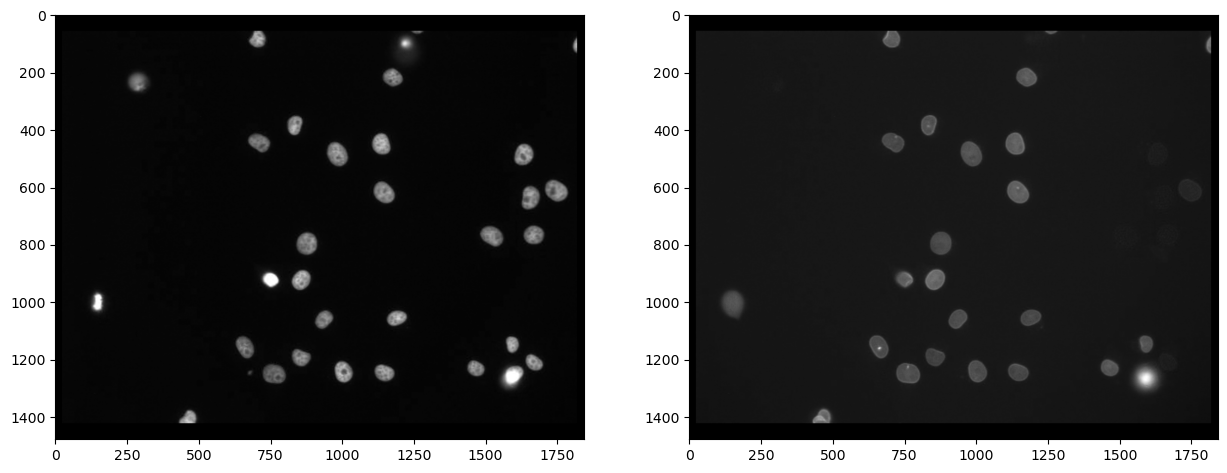

In [3]:
# extract channels
channel_0 = raw_image[...,0]
channel_1 = raw_image[...,1]

# visualize
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(channel_0, cmap='gray')
axs[1].imshow(channel_1, cmap='gray')

## Segmenting nuclei
As the staining marks the whole nucleus in both cases, it is reasonable to segmentn nuclei in both images and then process the segmented images further. We use [Voronoi-Otsu-Labeling](https://github.com/clEsperanto/pyclesperanto_prototype/blob/f9c9b73c1f9f194fdabdab8bd8507eb73c3ef8c9/demo/segmentation/voronoi_otsu_labeling.ipynb) for the segmentation because it is a quick and straightforward approach.

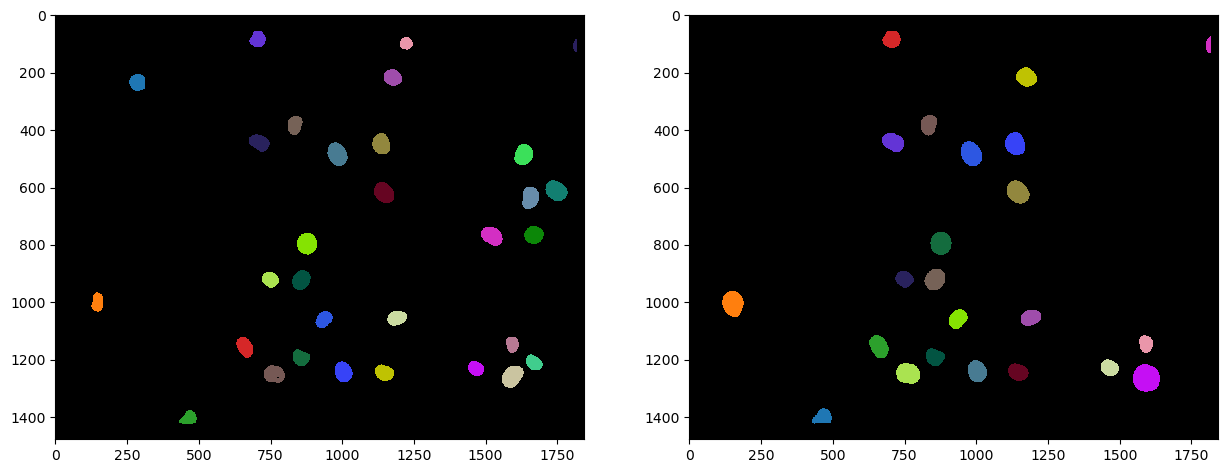

In [4]:
# segmentation
nuclei_cy3 = cle.voronoi_otsu_labeling(channel_0, spot_sigma=20)
nuclei_egfp = cle.voronoi_otsu_labeling(channel_1, spot_sigma=20)

# visualize
fig, axs = plt.subplots(1, 2, figsize=(15,15))
cle.imshow(nuclei_cy3, plot=axs[0], labels=True)
cle.imshow(nuclei_egfp, plot=axs[1], labels=True)

The above shown label images have inside nuclei pixel intensity values that correspond to the number of the nucleus. In nucleus 1, all pixels have intensity 1. In nucleus 2, all pixels have intensity 2 and so on. We can then reduce these images to their centroids to later determine distances between objects in multiple channels.

In [5]:
centroids_cy3 = cle.centroids_of_labels(nuclei_cy3)
centroids_egfp = cle.centroids_of_labels(nuclei_egfp)

These `centroids_...` variables are coordinate lists. Hence, if we print out their `shape`, we can already note that there are more `cy3` positive nuclei than `egfp` postives:

In [6]:
print(centroids_cy3.shape, centroids_egfp.shape)

(2, 31) (2, 23)


## Distance matrix
We compute now the distance of all `centroids_cy3` versus all `centroids_egfp`. Note the shape of the distance matrix tells us that all `cy3` positives lie on the x-axis and `egfp`-positive centroids on the y-axis:

cl.OCLArray([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.54030752e+00, 7.82682983e+02, 5.06495544e+02,
        5.30497314e+02, 1.07481958e+03, 7.91600891e+02, 6.02906616e+02,
        6.57973022e+02, 9.23156311e+02, 7.09134155e+02, 7.27826721e+02,
        7.54115051e+02, 7.85373596e+02, 9.79799500e+02, 8.83578003e+02,
        1.12951721e+03, 1.06510938e+03, 1.02250336e+03, 1.29149976e+03,
        1.03813599e+03, 1.40257227e+03, 1.33171460e+03, 1.38857349e+03,
        1.44623132e+03, 1.46175098e+03, 1.56747668e+03, 1.54672949e+03,
        1.52855164e+03, 1.53324097e+03, 1.64022278e+03, 1.88720886e+03],
       [0.00000000e+00, 5.10154297e+02, 1.17952515e+03, 3.36981773e+00,
        3.12130341e+02, 1.33841968e+03, 9.87138794e+02, 5.56908508e+02,
        3.32706848e+02, 1.08204810e+03, 6.17555237e+02, 4.41588989e+02,
        7.31238953e+02, 5.80590820e+02, 1.05177051e+03, 5.60654663e+02,
        1.16359900e+03, 1.03594714e+03, 6.98219299e+02, 1.38013428e+03,
        8.02029785e+02, 1.50617249e+03, 1.01399646e+03, 1.22979492e+03,
        1.15475610e+03, 1.13583630e+03, 1.48195923e+03, 1.41370728e+03,
        1.21688196e+03, 1.35897009e+03, 1.50313525e+03, 1.86785327e+03],
       [0.00000000e+00, 5.35841309e+02, 9.93919250e+02, 3.16157806e+02,
        1.96462023e+00, 1.07249683e+03, 7.12699951e+02, 2.49930725e+02,
        1.40156082e+02, 7.91201904e+02, 3.03902435e+02, 1.98405533e+02,
        4.19099365e+02, 2.90854492e+02, 7.43736328e+02, 3.53693512e+02,
        8.50658508e+02, 7.22632446e+02, 4.93788727e+02, 1.07002319e+03,
        5.37767090e+02, 1.19674622e+03, 8.07613220e+02, 9.42470215e+02,
        9.30908752e+02, 9.36963013e+02, 1.17886414e+03, 1.12100635e+03,
        1.00781512e+03, 1.07871594e+03, 1.21250403e+03, 1.55736768e+03],
       [0.00000000e+00, 1.07322717e+03, 4.44709717e+02, 1.34140869e+03,
        1.07418213e+03, 2.99143344e-01, 3.60388367e+02, 8.38776001e+02,
        1.16903174e+03, 3.26066498e+02, 8.52533081e+02, 1.12009851e+03,
        7.32585449e+02, 1.00352087e+03, 4.87072693e+02, 1.19727197e+03,
        5.64549683e+02, 6.92142578e+02, 1.24332935e+03, 4.88558960e+02,
        1.08580481e+03, 5.17053101e+02, 1.37598035e+03, 1.06557239e+03,
        1.38423206e+03, 1.47200183e+03, 1.00960040e+03, 1.09812476e+03,
        1.48162659e+03, 1.17885876e+03, 1.16573645e+03, 1.10616272e+03],
       [0.00000000e+00, 7.92731567e+02, 4.72356018e+02, 9.91693481e+02,
        7.16097290e+02, 3.59227783e+02, 1.44743443e+00, 4.80279114e+02,
        8.10389648e+02, 1.37372757e+02, 5.01802399e+02, 7.64911011e+02,
        3.90457062e+02, 6.57536316e+02, 2.74826294e+02, 8.52490784e+02,
        4.24979950e+02, 4.68381104e+02, 9.14044312e+02, 5.16654724e+02,
        7.77781250e+02, 6.16704651e+02, 1.09106836e+03, 8.73643677e+02,
        1.12793872e+03, 1.20113501e+03, 9.21702576e+02, 9.63377625e+02,
        1.22668213e+03, 1.00929248e+03, 1.04773645e+03, 1.15111658e+03],
       [0.00000000e+00, 6.07224548e+02, 8.26992432e+02, 5.61124695e+02,
        2.53395782e+02, 8.37353088e+02, 4.77123962e+02, 1.71319878e+00,
        3.31987091e+02, 5.43207520e+02, 1.07321236e+02, 2.93860229e+02,
        1.77609116e+02, 2.33582336e+02, 4.93634949e+02, 4.11359741e+02,
        6.08618408e+02, 4.97022858e+02, 5.13842285e+02, 8.21771912e+02,
        4.60428864e+02, 9.47818848e+02, 7.80239624e+02, 7.85852539e+02,
        8.72365906e+02, 9.08227234e+02, 9.82798645e+02, 9.48379517e+02,
        9.62703552e+02, 9.30
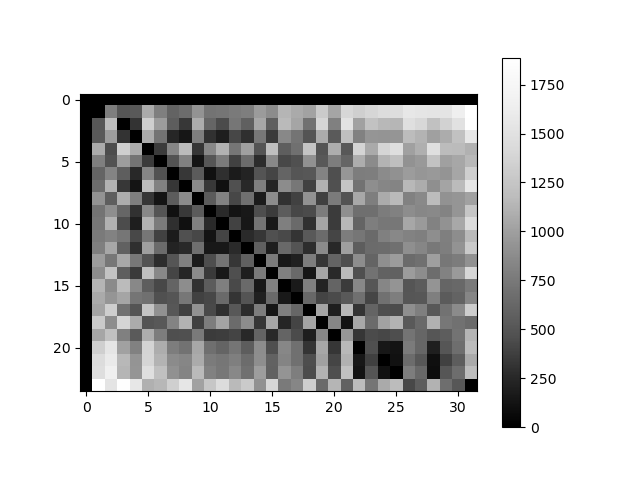
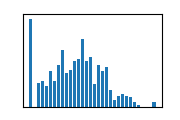

In [7]:
distance_matrix = cle.generate_distance_matrix(centroids_cy3, centroids_egfp)
distance_matrix

This matrix can be thresholded to count the number of positive objects which are in a given radius of objects in the other channel. Therefore, we fix a threshold taking the pixel size into account.

In [8]:
maximum_distance_in_micron = 5
maximum_distnace_in_pixels = maximum_distance_in_micron / pixel_size_xy_in_micron
maximum_distnace_in_pixels

15.625

cl.OCLArray([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)
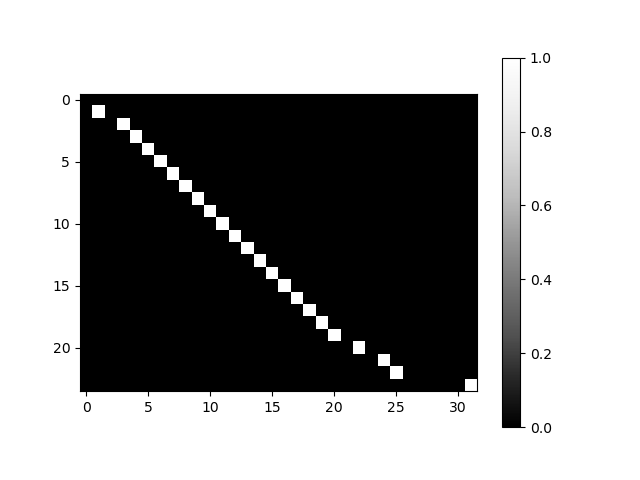
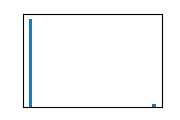

In [9]:
binary_neighbor_count_matrix = distance_matrix < maximum_distnace_in_pixels

# we do not want to count background as a close-by object
cle.set_column(binary_neighbor_count_matrix, 0, 0)
cle.set_row(binary_neighbor_count_matrix, 0, 0)

binary_neighbor_count_matrix

## Counting neighbors
We can now count for each cy3-positive nucleus the number of objects that are also egfp-positive by projecting this matrix in y:

In [10]:
positive_cy3_double_positive = np.asarray(cle.maximum_y_projection(binary_neighbor_count_matrix))[0, 1:]
# [0, 1:] is necessary to get rid of the first column which corresponds to background
positive_cy3_double_positive

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

There are that many cy3 positives that are also egfp positive:

In [11]:
positive_cy3_double_positive.sum()

23.0

There are that many cy3 positives that are egfp negative

In [12]:
(positive_cy3_double_positive == 0).sum()

8

Analogously, we can count the egfp positives that are also cy3 positive using a maximum-projection in x:

In [13]:
positive_egfp_double_positive = np.asarray(cle.maximum_x_projection(binary_neighbor_count_matrix))[1:,0]
# [1:, 0] is necessary to get rid of the first column which corresponds to background
positive_egfp_double_positive

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.], dtype=float32)

There are that many egfp positives that are also cy3 positive:

In [14]:
positive_egfp_double_positive.sum()

23.0

And there are that many egfp positives that are cy3 negative:

In [15]:
(positive_egfp_double_positive == 0).sum()

0